In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, GCNConv, global_mean_pool
from torch_geometric.data import Data, DataLoader
import json
import networkx as nx
from collections import defaultdict
import random
import matplotlib.pyplot as plt

# Data

In [12]:
# Load the graph data from the JSON file
with open('Dataset/Graphs.JSON', 'r') as file:
    graph_data = json.load(file)

def analyze_graph_dataset(graph_data):
    # Extract all node types from graph_data
    node_types = []
    node_type_counts = defaultdict(int)
    
    for graph_item in graph_data:
        if "Graph" in graph_item:
            graph_info = graph_item["Graph"]
            if "Nodes" in graph_info:
                for node in graph_info["Nodes"]:
                    if "Properties" in node:
                        node_props = node["Properties"]
                        node_type = node_props.get("Type")
                        if node_type is not None:  # Skip null/None values
                            node_types.append(node_type)
                            node_type_counts[node_type] += 1
    
    # Get unique types
    unique_types = sorted(set(node_types))
    
    # Print results
    print(f"Found {len(unique_types)} unique node types across {len(node_types)} nodes")
    print("\nNode type distribution:")
    for node_type, count in sorted(node_type_counts.items(), key=lambda x: x[1], reverse=True):
        percentage = (count / len(node_types)) * 100
        print(f"{node_type}: {count} ({percentage:.1f}%)")
    
    # Automatically create node type to index mapping
    # Sort by frequency (most common types get lowest indices)
    node_type_to_idx = {}
    for idx, (node_type, _) in enumerate(sorted(node_type_counts.items(), key=lambda x: x[1], reverse=True)):
        node_type_to_idx[node_type] = idx
        
    print("\nGenerated node type mapping:")
    for node_type, idx in node_type_to_idx.items():
        print(f"'{node_type}': {idx}")
    
    # Now analyze the graph dataset for null types
    total_graphs = 0
    graphs_with_all_valid_nodes = 0
    graphs_with_some_null_nodes = 0
    graphs_with_all_null_nodes = 0

    # --- Added: Collect indices of graphs with any null node types ---
    indices_with_null_nodes = []
    
    for i, graph_item in enumerate(graph_data):
        if "Graph" in graph_item:
            total_graphs += 1
            graph_info = graph_item["Graph"]
            
            total_nodes = 0
            null_nodes = 0
            
            if "Nodes" in graph_info:
                for node in graph_info["Nodes"]:
                    if "Properties" in node:
                        total_nodes += 1
                        node_props = node["Properties"]
                        node_type = node_props.get("Type")
                        
                        if node_type is None or node_type not in node_type_to_idx:
                            null_nodes += 1
            # Analyze this graph based on node types
            if total_nodes == 0:
                graphs_with_all_null_nodes += 1
                indices_with_null_nodes.append(i)
            elif null_nodes == total_nodes:
                graphs_with_all_null_nodes += 1
                indices_with_null_nodes.append(i)
            elif null_nodes > 0:
                graphs_with_some_null_nodes += 1
                indices_with_null_nodes.append(i)
            else:
                graphs_with_all_valid_nodes += 1
    
    # Print results
    print(f"\nGraph Dataset Analysis:")
    print(f"Total graphs in dataset: {total_graphs}")
    print(f"Graphs with all valid nodes: {graphs_with_all_valid_nodes}")
    print(f"Graphs with some null node types: {graphs_with_some_null_nodes}")
    print(f"Graphs with all null node types: {graphs_with_all_null_nodes}")
    print(f"Graphs that would be removed: {len(indices_with_null_nodes)}")
    print(f"Remaining valid graphs: {total_graphs - len(indices_with_null_nodes)}")

    # --- Added: Remove all graphs with any null node types ---
    filtered_graph_data = [g for i, g in enumerate(graph_data) if i not in indices_with_null_nodes]
    print(f"\nFiltered out {len(graph_data) - len(filtered_graph_data)} graphs with null node types.")
    
    return unique_types, node_type_counts, node_type_to_idx, filtered_graph_data

# Analyze the node types in our dataset and filter graphs
unique_types, type_counts, node_type_to_idx, graph_data = analyze_graph_dataset(graph_data)

Found 4 unique node types across 481 nodes

Node type distribution:
Bed: 183 (38.0%)
Bath: 104 (21.6%)
Living: 100 (20.8%)
Circulation: 94 (19.5%)

Generated node type mapping:
'Bed': 0
'Bath': 1
'Living': 2
'Circulation': 3

Graph Dataset Analysis:
Total graphs in dataset: 100
Graphs with all valid nodes: 100
Graphs with some null node types: 0
Graphs with all null node types: 0
Graphs that would be removed: 0
Remaining valid graphs: 100

Filtered out 0 graphs with null node types.


Loaded 100 valid graphs
Unique node-edge count combinations: 5


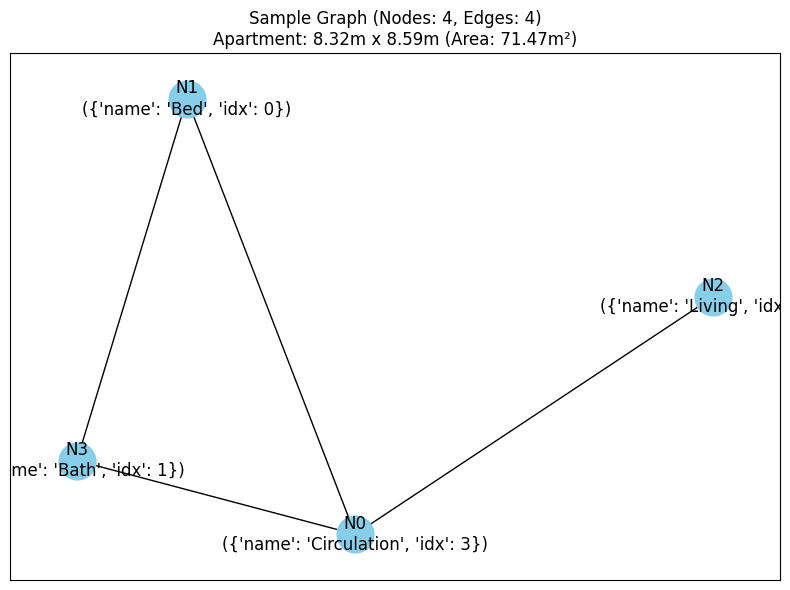


First Graph Details:
Apartment Dimensions: 8.32m x 8.59m
Apartment Area: 71.47m²
Program Vector: {'Bath': 1, 'Bed': 1, 'Circulation': 1, 'Living': 1}

Node Details:

Node N0:
  type: {'name': 'Circulation', 'idx': 3}
  x: 3.54
  y: 1.96
  apartment_width: 8.32
  apartment_length: 8.59
  apartment_area: 71.47
  program_vector: {'Bath': 1, 'Bed': 1, 'Circulation': 1, 'Living': 1}

Node N1:
  type: {'name': 'Bed', 'idx': 0}
  x: 2.21
  y: 6.27
  apartment_width: 8.32
  apartment_length: 8.59
  apartment_area: 71.47
  program_vector: {'Bath': 1, 'Bed': 1, 'Circulation': 1, 'Living': 1}

Node N2:
  type: {'name': 'Living', 'idx': 2}
  x: 6.37
  y: 4.31
  apartment_width: 8.32
  apartment_length: 8.59
  apartment_area: 71.47
  program_vector: {'Bath': 1, 'Bed': 1, 'Circulation': 1, 'Living': 1}

Node N3:
  type: {'name': 'Bath', 'idx': 1}
  x: 1.34
  y: 2.69
  apartment_width: 8.32
  apartment_length: 8.59
  apartment_area: 71.47
  program_vector: {'Bath': 1, 'Bed': 1, 'Circulation': 1, 'Li

In [16]:
# Process the graphs
graph_list = []
node_edge_counts = defaultdict(list)

for graph_item in graph_data:  # Each item in the list is a graph
    if "Graph" in graph_item:
        graph_info = graph_item["Graph"]
        
        # Create a new graph
        G = nx.Graph()
        
        # Extract apartment dimensions from Graph properties
        apartment_width = round(graph_info.get("Attributes", {}).get("Width", 7), 2)  # default 7 if not found
        apartment_length = round(graph_info.get("Attributes", {}).get("Length", 10), 2)  # default 10 if not found
        apartment_area = round(apartment_width * apartment_length, 2)  # Calculate area
        
        # First pass: Count room types in this specific graph
        temp_counts = defaultdict(int)
        if "Nodes" in graph_info:
            for node in graph_info["Nodes"]:
                if "Properties" in node:
                    node_type = node["Properties"].get("Type")
                    if node_type is not None:
                        temp_counts[node_type] += 1
        
        # Create ordered program vector based on unique_types
        program_vector = {room_type: temp_counts.get(room_type, 0) for room_type in unique_types}
        
        # Add dimensions, area and program vector to graph attributes
        G.graph['width'] = apartment_width
        G.graph['length'] = apartment_length
        G.graph['area'] = apartment_area
        G.graph['program_vector'] = program_vector
        
        # Second pass: Add nodes with awareness of all room counts
        if "Nodes" in graph_info:
            for node in graph_info["Nodes"]:
                if "Properties" in node:
                    node_props = node["Properties"]
                    node_id = node_props.get("Id")
                    node_type = node_props.get("Type")
                    if node_id is not None and node_type is not None:
                        # Store node properties
                        G.add_node(node_id, 
                                 type={'name': node_type, 
                                      'idx': node_type_to_idx[node_type]},
                                 x=round(node_props.get("Point", {}).get("X"), 2),
                                 y=round(node_props.get("Point", {}).get("Y"), 2),
                                 apartment_width=apartment_width,
                                 apartment_length=apartment_length,
                                 apartment_area=apartment_area,
                                 program_vector=program_vector)
        # Process edges 
        if "Edges" in graph_info:
            for edge in graph_info["Edges"]:
                if "Properties" in edge:
                    edge_props = edge["Properties"]
                    source_id = edge_props.get("SourceId")
                    target_id = edge_props.get("TargetId")
                    if source_id is not None and target_id is not None:
                        G.add_edge(source_id, target_id)
        
        if len(G.nodes) > 0:  # Only add non-empty graphs
            graph_list.append(G)
            node_edge_counts[(len(G.nodes), len(G.edges))].append(G)

print(f"Loaded {len(graph_list)} valid graphs")
print(f"Unique node-edge count combinations: {len(node_edge_counts)}")

graph_index = 3  # Index of the graph you want to inspect

# Plot one example graph with node types (unchanged)
if graph_list:
    plt.figure(figsize=(8, 6))
    sample_graph = graph_list[graph_index]
    
    pos = {node: (data.get('x', 0), data.get('y', 0)) 
           for node, data in sample_graph.nodes(data=True)}
    
    nx.draw_networkx_nodes(sample_graph, pos, 
                          node_color='skyblue',
                          node_size=700)
    
    nx.draw_networkx_edges(sample_graph, pos)
    
    labels = {node: f"{node}\n({data.get('type', 'unknown')})" 
             for node, data in sample_graph.nodes(data=True)}
    nx.draw_networkx_labels(sample_graph, pos, labels)
    
    plt.title(f"Sample Graph (Nodes: {len(sample_graph.nodes)}, Edges: {len(sample_graph.edges)})\n"
              f"Apartment: {sample_graph.graph['width']}m x {sample_graph.graph['length']}m (Area: {sample_graph.graph['area']}m²)")
    plt.tight_layout()
    plt.show()

# Print details of the first graph
if graph_list:
    sample_graph = graph_list[graph_index]
    print("\nFirst Graph Details:")
    print(f"Apartment Dimensions: {sample_graph.graph['width']}m x {sample_graph.graph['length']}m")
    print(f"Apartment Area: {sample_graph.graph['area']}m²")
    print(f"Program Vector: {sample_graph.graph['program_vector']}")
    print("\nNode Details:")
    for node, data in sample_graph.nodes(data=True):
        print(f"\nNode {node}:")
        for key, value in data.items():
            print(f"  {key}: {value}")

In [17]:

# Two-way conversion functions
def type_to_int(node_type):
    """Convert a node type string to its integer representation
    
    Args:
        node_type (str): The node type as a string (e.g., 'Bed')
        
    Returns:
        int: The integer code for the node type, or -1 if not found
    """
    # Handle case where node_type is None
    if not node_type:
        return -1
        
    # Return the integer code or -1 if not found
    return node_type_to_idx.get(node_type, -1)

def int_to_type(type_code):
    """Convert an integer node type code back to its string representation
    
    Args:
        type_code (int): The integer code for the node type
        
    Returns:
        str: The node type as a string, or 'unknown' if not found
    """
    # Create reverse mapping
    idx_to_type = {v: k for k, v in node_type_to_idx.items()}
    # Return the node type string or 'unknown' if not found
    return idx_to_type.get(type_code, 'unknown')

In [22]:
# Create PyTorch Geometric dataset from NetworkX graphs
processed_graphs = []

# Define type encoding maps for consistency
type_encodings = {name: idx for idx, name in enumerate(unique_types)}
reverse_encodings = {idx: name for name, idx in type_encodings.items()}

def get_node_type(features):
    """Extract node type from feature vector"""
    if len(features) >= 3:
        type_code = int(round(features[2]))
        return reverse_encodings.get(type_code, 'unknown')
    return 'unknown'

for i, graph in enumerate(graph_list):
    try:
        print(f"Processing graph {i+1}/{len(graph_list)}")
        print(f"  - Nodes: {len(graph.nodes)}, Edges: {len(graph.edges)}")
        
        # Extract node features: x, y coordinates and type idx
        x = []
        for node, data in graph.nodes(data=True):
            try:
                # Print node data to debug the issue
                if 'type' not in data:
                    print(f"  - ERROR: Node {node} is missing 'type' attribute")
                    print(f"  - Available attributes: {list(data.keys())}")
                    continue
                    
                if not isinstance(data['type'], dict):
                    print(f"  - ERROR: Node {node}'s 'type' is not a dictionary, it's {type(data['type'])}")
                    print(f"  - Value: {data['type']}")
                    continue
                    
                if 'idx' not in data['type']:
                    print(f"  - ERROR: Node {node}'s type dictionary is missing 'idx' key")
                    print(f"  - Available keys: {list(data['type'].keys())}")
                    continue
                
                node_type_idx = data['type']['idx']
                x.append([
                    data['x'] / graph.graph['width'],  # Normalize x coordinate
                    data['y'] / graph.graph['length'],  # Normalize y coordinate
                    node_type_idx  # Node type as integer code
                ])
            except Exception as e:
                print(f"  - Error processing node {node}: {str(e)}")
                print(f"  - Node data: {data}")
                
        if not x:
            print("  - No valid nodes found, skipping graph")
            continue
            
        x_tensor = torch.tensor(x, dtype=torch.float)
        
        # Create edge index
        edge_index = []
        for source, target in graph.edges():
            try:
                # Get the index of these nodes in the current list of valid nodes
                node_list = [n for n, d in graph.nodes(data=True) 
                           if 'type' in d and isinstance(d['type'], dict) and 'idx' in d['type']]
                
                if source not in node_list or target not in node_list:
                    print(f"  - Skipping edge {source}-{target}: one or both nodes were invalid")
                    continue
                    
                source_idx = node_list.index(source)
                target_idx = node_list.index(target)
                edge_index.append([source_idx, target_idx])
                edge_index.append([target_idx, source_idx])  # Add in both directions for undirected graph
            except Exception as e:
                print(f"  - Error processing edge {source}-{target}: {str(e)}")
        
        if len(edge_index) > 0:
            edge_index_tensor = torch.tensor(edge_index, dtype=torch.long).t()
            # --- Add area, apartment dimensions, and program vector as attributes ---
            data_obj = Data(
                x=x_tensor,
                edge_index=edge_index_tensor,
                area=torch.tensor([graph.graph['area']], dtype=torch.float),
                apartment_width=torch.tensor([graph.graph['width']], dtype=torch.float),
                apartment_length=torch.tensor([graph.graph['length']], dtype=torch.float),
                program_vector=torch.tensor([list(graph.graph['program_vector'].values())], dtype=torch.float)
            )
            processed_graphs.append(data_obj)
            print(f"  - Successfully added graph with {len(x)} nodes and {len(edge_index)//2} edges")
        else:
            print("  - No valid edges found, skipping graph")
            
    except Exception as e:
        print(f"  - Failed to process graph {i+1}: {str(e)}")

print(f"Created {len(processed_graphs)} PyTorch Geometric graph objects")

# Print summary of processed graphs
if processed_graphs:
    print("\nSummary of processed graphs:")
    for i, data in enumerate(processed_graphs):
        print(f"Graph {i+1}: Nodes={data.num_nodes}, Edges={data.num_edges//2}")
        # Print first node features as a sample
        if data.num_nodes > 0:
            print(f"  - Sample node features: {data.x[0]}")

Processing graph 1/100
  - Nodes: 5, Edges: 5
  - Successfully added graph with 5 nodes and 5 edges
Processing graph 2/100
  - Nodes: 6, Edges: 6
  - Successfully added graph with 6 nodes and 6 edges
Processing graph 3/100
  - Nodes: 6, Edges: 6
  - Successfully added graph with 6 nodes and 6 edges
Processing graph 4/100
  - Nodes: 4, Edges: 4
  - Successfully added graph with 4 nodes and 4 edges
Processing graph 5/100
  - Nodes: 5, Edges: 5
  - Successfully added graph with 5 nodes and 5 edges
Processing graph 6/100
  - Nodes: 5, Edges: 5
  - Successfully added graph with 5 nodes and 5 edges
Processing graph 7/100
  - Nodes: 4, Edges: 4
  - Successfully added graph with 4 nodes and 4 edges
Processing graph 8/100
  - Nodes: 4, Edges: 4
  - Successfully added graph with 4 nodes and 4 edges
Processing graph 9/100
  - Nodes: 5, Edges: 5
  - Successfully added graph with 5 nodes and 5 edges
Processing graph 10/100
  - Nodes: 4, Edges: 4
  - Successfully added graph with 4 nodes and 4 edges

In [23]:
# Let's take a graph node and print its tensor representation
# Let's choose a graph from our list
sample_graph_index = 12  # You can change this to explore different graphs
sample_graph = graph_list[sample_graph_index]

# Find the corresponding processed PyG graph
processed_graph = processed_graphs[sample_graph_index]

print(f"Graph {sample_graph_index} Details:")
print(f"Original graph: {len(sample_graph.nodes)} nodes, {len(sample_graph.edges)} edges")
print(f"PyG graph: {processed_graph.num_nodes} nodes, {processed_graph.num_edges//2} edges")
print("\nNode Data:")

# Display each node in the graph and its tensor representation
for i, (node, data) in enumerate(sample_graph.nodes(data=True)):
    # Print original node data
    print(f"\nNode {node}:")
    print(f"  Type: {data['type']}")
    print(f"  Position: ({data['x']:.2f}, {data['y']:.2f})")
    
    # Print corresponding tensor representation
    if i < processed_graph.num_nodes:
        tensor_repr = processed_graph.x[i]
        print(f"  Tensor representation: {tensor_repr}")
        print(f"  - Normalized X: {tensor_repr[0]:.4f}")
        print(f"  - Normalized Y: {tensor_repr[1]:.4f}")
        print(f"  - Type encoding: {int(tensor_repr[2])}")
        print(f"  - Type decoded: {get_node_type(tensor_repr.tolist())}")

Graph 12 Details:
Original graph: 5 nodes, 5 edges
PyG graph: 5 nodes, 5 edges

Node Data:

Node N0:
  Type: {'name': 'Circulation', 'idx': 3}
  Position: (3.91, 3.23)
  Tensor representation: tensor([0.4683, 0.3024, 3.0000])
  - Normalized X: 0.4683
  - Normalized Y: 0.3024
  - Type encoding: 3
  - Type decoded: Living

Node N1:
  Type: {'name': 'Bed', 'idx': 0}
  Position: (1.62, 1.47)
  Tensor representation: tensor([0.1940, 0.1376, 0.0000])
  - Normalized X: 0.1940
  - Normalized Y: 0.1376
  - Type encoding: 0
  - Type decoded: Bath

Node N2:
  Type: {'name': 'Bed', 'idx': 0}
  Position: (6.47, 2.16)
  Tensor representation: tensor([0.7749, 0.2022, 0.0000])
  - Normalized X: 0.7749
  - Normalized Y: 0.2022
  - Type encoding: 0
  - Type decoded: Bath

Node N3:
  Type: {'name': 'Living', 'idx': 2}
  Position: (4.17, 7.50)
  Tensor representation: tensor([0.4994, 0.7022, 2.0000])
  - Normalized X: 0.4994
  - Normalized Y: 0.7022
  - Type encoding: 2
  - Type decoded: Circulation

Node

# Model

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, GCNConv, global_mean_pool
from torch_geometric.data import Data, DataLoader
import json
import networkx as nx
from collections import defaultdict
import random
import matplotlib.pyplot as plt

# Negative sampling function implementation
def negative_sampling(edge_index, num_nodes, num_neg_samples=None):
    """Generate negative samples by creating random edges that don't exist in the graph."""
    # If num_neg_samples not specified, use same number as positive edges
    num_neg_samples = num_neg_samples or edge_index.size(1)
    
    # Create all possible edges as a 2D tensor
    all_edges = set()
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j:  # Exclude self-loops
                all_edges.add((i, j))
    
    # Remove existing edges
    existing_edges = set(tuple(e) for e in edge_index.t().tolist())
    candidate_edges = list(all_edges - existing_edges)
    
    # Randomly select negative edges
    if len(candidate_edges) <= num_neg_samples:
        neg_edges = candidate_edges  # If not enough candidates, use all
    else:
        neg_edges = random.sample(candidate_edges, num_neg_samples)
    
    # Convert to tensor
    neg_edge_index = torch.tensor(neg_edges, dtype=torch.long).t()
    
    # Ensure we're on the same device as the input
    return neg_edge_index.to(edge_index.device)

class GraphGenerator(nn.Module):
    def __init__(self, node_features=3, hidden_dim=64):
        super(GraphGenerator, self).__init__()
        self.hidden_dim = hidden_dim
        
        # Ensure input features are handled correctly
        self.conv1 = GATConv(node_features, hidden_dim, heads=1)
        self.conv2 = GATConv(hidden_dim, hidden_dim, heads=1)
        self.conv3 = GATConv(hidden_dim, hidden_dim, heads=1)
        
        # Node prediction layers
        self.node_predictor = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, node_features)  # Output should match input features
        )
        
        # Edge prediction layer
        self.edge_predictor = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def encode(self, x, edge_index):
        # Apply convolutions with ReLU and dropout between layers
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.2, training=self.training)
        
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.2, training=self.training)
        
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.2, training=self.training)
        
        return x

    def decode_edges(self, z, edge_index):
        # Create edge features by concatenating node pairs
        row, col = edge_index
        edge_features = torch.cat([z[row], z[col]], dim=1)
        return self.edge_predictor(edge_features)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        # Encode the graph
        z = self.encode(x, edge_index)
        
        # Predict new node features
        new_node_features = self.node_predictor(z)
        
        # Predict edge probabilities
        edge_pred = self.decode_edges(z, edge_index)
        
        return new_node_features, edge_pred

# Train

c:\Users\baoqt\anaconda3\envs\311\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Error during training: mat1 and mat2 shapes cannot be multiplied (158x6 and 128x64)
Reducing batch size to 8
Error during training: mat1 and mat2 shapes cannot be multiplied (84x6 and 128x64)
Reducing batch size to 4
Error during training: mat1 and mat2 shapes cannot be multiplied (42x6 and 128x64)
Reducing batch size to 2
Error during training: mat1 and mat2 shapes cannot be multiplied (24x6 and 128x64)
Reducing batch size to 1
Batch size too small, stopping training


Traceback (most recent call last):
  File "C:\Users\baoqt\AppData\Local\Temp\ipykernel_28836\1296640322.py", line 57, in <module>
    loss = train()
           ^^^^^^^
  File "C:\Users\baoqt\AppData\Local\Temp\ipykernel_28836\1296640322.py", line 29, in train
    pos_edge_pred = model.decode_edges(new_node_features, pos_edge_index)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\baoqt\AppData\Local\Temp\ipykernel_28836\978599938.py", line 86, in decode_edges
    return self.edge_predictor(edge_features)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\baoqt\anaconda3\envs\311\Lib\site-packages\torch\nn\modules\module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\baoqt\anaconda3\envs\311\Lib\site-packages\torch\nn\modules\module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^

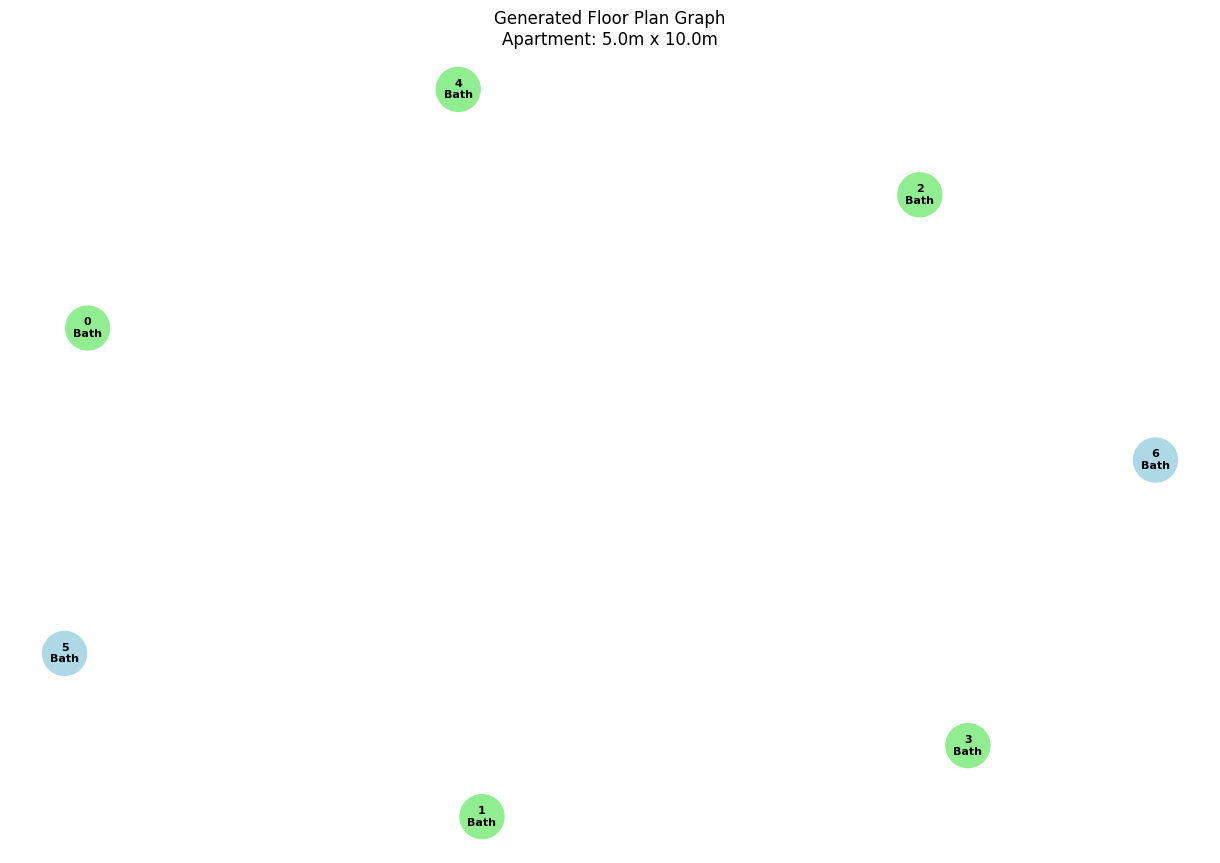


Graph Statistics:
Total nodes: 7
Total edges: 0

Node Types:
Node 0: Bath (Required)
Node 1: Bath (Required)
Node 2: Bath (Required)
Node 3: Bath (Required)
Node 4: Bath (Required)
Node 5: Bath (Generated)
Node 6: Bath (Generated)


In [20]:
# Create data loader with appropriate batch size - start with smaller batch size
batch_size = 16  # Reduced from 32 to avoid memory issues
train_loader = DataLoader(processed_graphs, batch_size=max(1, batch_size), shuffle=True)

# Initialize model
node_features = processed_graphs[0].x.size(1)  # Number of node features
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GraphGenerator(node_features=node_features).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Update the train function to include negative edge samples
def train():
    model.train()
    total_loss = 0
    
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        new_node_features, edge_pred = model(batch)
        
        # Node feature reconstruction loss
        node_loss = F.mse_loss(new_node_features, batch.x)
        
        # Edge prediction loss - with negative samples
        # Positive edges (existing edges)
        pos_edge_index = batch.edge_index
        pos_edge_pred = model.decode_edges(new_node_features, pos_edge_index)
        pos_edge_loss = F.binary_cross_entropy(pos_edge_pred.squeeze(), 
                                              torch.ones(pos_edge_index.size(1)).to(device))
        
        # Negative edges (randomly sample non-existing edges)
        neg_edge_index = negative_sampling(batch.edge_index, num_nodes=batch.num_nodes,
                                          num_neg_samples=batch.edge_index.size(1))
        neg_edge_pred = model.decode_edges(new_node_features, neg_edge_index)
        neg_edge_loss = F.binary_cross_entropy(neg_edge_pred.squeeze(), 
                                              torch.zeros(neg_edge_index.size(1)).to(device))
        
        edge_loss = pos_edge_loss + neg_edge_loss
        
        # Combined loss
        loss = node_loss + edge_loss
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(train_loader)

# Train the model with error handling
num_epochs = 100
for epoch in range(num_epochs):
    try:
        loss = train()
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1:03d}, Loss: {loss:.4f}')
    except Exception as e:
        print(f"Error during training: {e}")
        # Provide more detailed information about the error
        import traceback
        traceback.print_exc()
        # Reduce batch size and reinitialize dataloader if problems occur
        batch_size = max(1, batch_size // 2)
        print(f"Reducing batch size to {batch_size}")
        if batch_size < 2:
            print("Batch size too small, stopping training")
            break
        train_loader = DataLoader(processed_graphs, batch_size=batch_size, shuffle=True)
        continue


def generate_new_graph(model, required_nodes, apartment_width, apartment_length, num_additional_nodes):
    """
    Generate a graph with specified node requirements
    
    Args:
        model: Trained GraphGenerator model
        required_nodes: Dict[str, int] - Dictionary of required node types and their counts
        apartment_width: float - Width of the apartment
        apartment_length: float - Length of the apartment
        num_additional_nodes: int - Number of additional nodes to generate freely
    """
    model.eval()
    with torch.no_grad():
        # Calculate total number of nodes
        num_fixed_nodes = sum(required_nodes.values())
        total_nodes = num_fixed_nodes + num_additional_nodes
        
        # Initialize feature matrix with correct dimensions from model
        x = torch.zeros(total_nodes, 3).to(device)  # 3 features: x, y, type
        
        # Create features for required nodes
        current_idx = 0
        for node_type, count in required_nodes.items():
            type_code = type_encodings.get(node_type, 0)  # Get encoding for the node type
            for i in range(count):
                # Generate normalized spatial features (x, y coordinates)
                x_coord = torch.rand(1) * 0.8 + 0.1  # Keep away from edges (0.1 to 0.9)
                y_coord = torch.rand(1) * 0.8 + 0.1  # Keep away from edges (0.1 to 0.9)
                
                # Combine features
                x[current_idx] = torch.tensor([x_coord.item(), y_coord.item(), type_code])
                current_idx += 1
                
        # Generate features for additional nodes similarly
        if num_additional_nodes > 0:
            for i in range(num_additional_nodes):
                x_coord = torch.rand(1) * 0.8 + 0.1
                y_coord = torch.rand(1) * 0.8 + 0.1
                available_types = list(node_type_to_idx.keys())
                selected_type = random.choice(available_types)
                type_code = type_encodings.get(selected_type, 0)
                x[current_idx + i] = torch.tensor([x_coord.item(), y_coord.item(), type_code])
        
        # Create fully connected edge index
        edge_index = torch.tensor([[i, j] for i in range(total_nodes) 
                                 for j in range(total_nodes) if i != j],
                                dtype=torch.long).t().to(device)
        
        # Create data object and generate
        data = Data(x=x, edge_index=edge_index).to(device)
        new_features, edge_probs = model(data)
        
        # Keep only edges with high probability
        mask = edge_probs.squeeze() > 0.5
        final_edge_index = edge_index[:, mask]
        
        # Create NetworkX graph for visualization
        G = nx.Graph()
        for i in range(total_nodes):
            features = new_features[i].cpu().numpy()
            # Get node type from the type encoding
            node_type = get_node_type(features)
            
            # Add node with its properties
            G.add_node(i, 
                      type=node_type,
                      position=(features[0], features[1]),
                      fixed=(i < num_fixed_nodes))  # Mark if it's a required node
        
        edges = final_edge_index.t().cpu().numpy()
        for edge in edges:
            G.add_edge(int(edge[0]), int(edge[1]))
        
        return G

# Example usage with specific apartment dimensions
required_nodes = {
    'bedroom': 2,
    'bathroom': 1,
    'kitchen': 1,
    'living_room': 1
}

# Test the model with specific dimensions
apartment_width = 5.0  # meters
apartment_length = 10.0  # meters
num_additional_nodes = 2  # Additional rooms to generate

# Generate new graph
new_graph = generate_new_graph(
    model=model,
    required_nodes=required_nodes,
    apartment_width=apartment_width,
    apartment_length=apartment_length,
    num_additional_nodes=num_additional_nodes
)

# Visualize the result
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(new_graph)
node_colors = ['lightgreen' if new_graph.nodes[n]['fixed'] else 'lightblue' 
               for n in new_graph.nodes()]
node_labels = {n: f"{n}\n{new_graph.nodes[n]['type']}" for n in new_graph.nodes()}

nx.draw(new_graph, pos=pos, 
        with_labels=True,
        node_color=node_colors,
        node_size=1000,
        font_size=8,
        font_weight='bold',
        labels=node_labels)

plt.title(f"Generated Floor Plan Graph\nApartment: {apartment_width}m x {apartment_length}m")
plt.show()

# Print graph statistics
print("\nGraph Statistics:")
print(f"Total nodes: {new_graph.number_of_nodes()}")
print(f"Total edges: {new_graph.number_of_edges()}")
print("\nNode Types:")
for node, attr in new_graph.nodes(data=True):
    print(f"Node {node}: {attr['type']} ({'Required' if attr['fixed'] else 'Generated'})")